In [94]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import f1_score, calinski_harabasz_score, jaccard_score, adjusted_rand_score

In [3]:
dataset = pd.read_csv('new-thyroid.csv')
dataset.head()

,2,3,4,5,6,class
0,107,10.1,2.2,0.9,2.7,1
1,113,9.9,3.1,2.0,5.9,1
2,127,12.9,2.4,1.4,0.6,1
3,109,5.3,1.6,1.4,1.5,1
4,105,7.3,1.5,1.5,-0.1,1


In [19]:
unique_classes = dataset["class"].unique()
classes_number = len(unique_classes)

dictionary = {}
for i in range(classes_number):
    dictionary[unique_classes[i]] = i
    
n = dataset.shape[0]
m = dataset.shape[1] - 1

dataset["class"] = dataset.apply(lambda x: dictionary[x[m]], axis = 1)

dataset.head()

,2,3,4,5,6,class
0,107,10.1,2.2,0.9,2.7,0
1,113,9.9,3.1,2.0,5.9,0
2,127,12.9,2.4,1.4,0.6,0
3,109,5.3,1.6,1.4,1.5,0
4,105,7.3,1.5,1.5,-0.1,0


In [20]:
X = dataset[dataset.columns[:-1]]
X.head()

,2,3,4,5,6
0,107,10.1,2.2,0.9,2.7
1,113,9.9,3.1,2.0,5.9
2,127,12.9,2.4,1.4,0.6
3,109,5.3,1.6,1.4,1.5
4,105,7.3,1.5,1.5,-0.1


In [69]:
X_norm = MinMaxScaler(copy=True).fit_transform(X)

In [36]:
X_reduced = PCA(n_components=2).fit_transform(X_norm)

In [46]:
y = dataset["class"]
unique_classes, count = np.unique(y, return_counts=True)
dict(zip(classes, count))

{0: 150, 1: 35, 2: 30}

In [47]:
colours = ["b", "g", "r"]

def display_clusters(labels, title):
    plt.figure(figsize=(16, 9))
    for i in range(len(unique_classes)):
        label = unique_classes[i]
        cur_xs = X_reduced[labels == label, 0]
        cur_ys = X_reduced[labels == label, 1]
        plt.scatter(cur_xs, cur_ys, color=colours[i], alpha=0.5, label=label)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

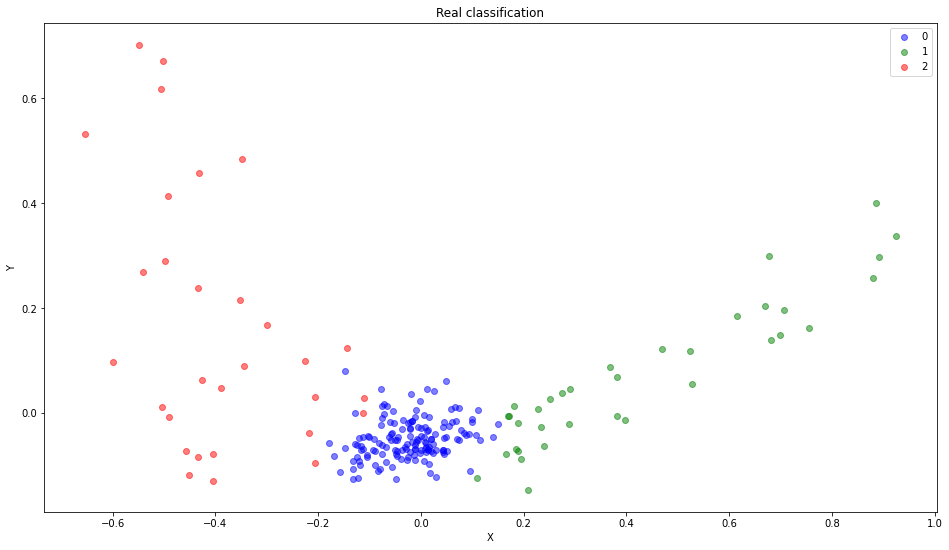

In [48]:
display_clusters(y, "Real classification")

In [83]:
class KMeans:
    def __init__(self, n_clusters, eps=1e-7, max_iters=10000):
        self.n_clusters = n_clusters
        self.eps = eps
        self.max_iters = max_iters
        
    def init_centroids(self, X):
        cnt, dim = X.shape
        centroids = []
        first_idx = np.random.randint(0, cnt)
        centroids.append(X[first_idx])
        for _ in range(self.n_clusters - 1):
            min_distances = np.apply_along_axis(lambda x: self.find_nearest(centroids, x)[1], 1, X)
            sorted_idxs = np.argsort(min_distances)
            dist_sum = np.sum(min_distances)
            p = random.random() + self.eps
            cur_dist = p * dist_sum
            cur_idx = 0
            cur_sum = min_distances[sorted_idxs[0]]
            while cur_sum < cur_dist:
                cur_idx += 1
                cur_sum += min_distances[sorted_idxs[cur_idx]]
            centroids.append(X[sorted_idxs[cur_idx]])
        self.centroids = np.array(centroids)
            
    def find_nearest(self, points, x):
        distances = np.apply_along_axis(lambda c: np.linalg.norm(c - x), 1, points)
        idx = np.argmin(distances)
        return idx, distances[idx]
        
    def find_nearest_centroid(self, x):
        idx, _ = self.find_nearest(self.centroids, x)
        return idx
        
    def fit(self, X):
        self.init_centroids(X)
        cnt, dim = X.shape
        for _ in range(self.max_iters):
            cluster_size = np.zeros(self.n_clusters, dtype=int)
            cluster_sum = np.zeros((self.n_clusters, dim))
            for x in X:
                c_idx = self.find_nearest_centroid(x)
                cluster_size[c_idx] += 1
                cluster_sum[c_idx] += x
            new_centroids = np.copy(self.centroids)
            for i in range(self.n_clusters):
                if cluster_size[i] != 0:
                    new_centroids[i] = cluster_sum[i] / cluster_size[i]
            diffs = np.apply_along_axis(lambda diff: np.linalg.norm(diff), 1, self.centroids - new_centroids)
            if np.max(diffs) <= self.eps:
                break
            self.centroids = new_centroids
            
    def transform_one(self, x):
        return self.find_nearest_centroid(x)
    
    def transform(self, X):
        return np.apply_along_axis(self.transform_one, 1, X)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

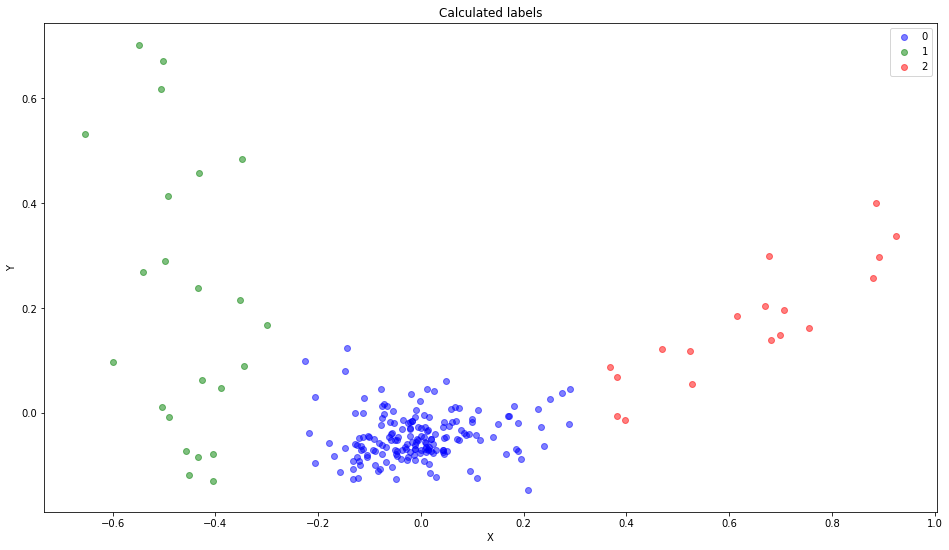

In [84]:
calculated_labels = KMeansPP(n_clusters=3).fit_transform(X_norm)
display_clusters(calculated_labels, "Calculated labels")

In [99]:
clusters_cnt = [i for i in range(2, 10)]
inner_metrics = []

f1_scores = []
jaccard_scores = []
adjusted_rand_scores = []

for clusters in clusters_cnt:
    labels = KMeans(n_clusters=clusters).fit_transform(X_norm)
    inner_metrics.append(calinski_harabasz_score(X_norm, labels))
    f1_scores.append(f1_score(y, labels, average='micro'))
    jaccard_scores.append(jaccard_score(y, labels, average='micro'))  
    adjusted_rand_scores.append(adjusted_rand_score(y, labels))    

In [91]:
def display_metrics(clusters, metrics, title):
    plt.figure(figsize=(16, 9))
    plt.grid(linestyle='--')
    plt.plot(clusters, metrics, linestyle='-',marker='.',color='r')
    plt.title(title)
    plt.xlabel("Clusters number")
    plt.ylabel("Metric score")
    plt.show()

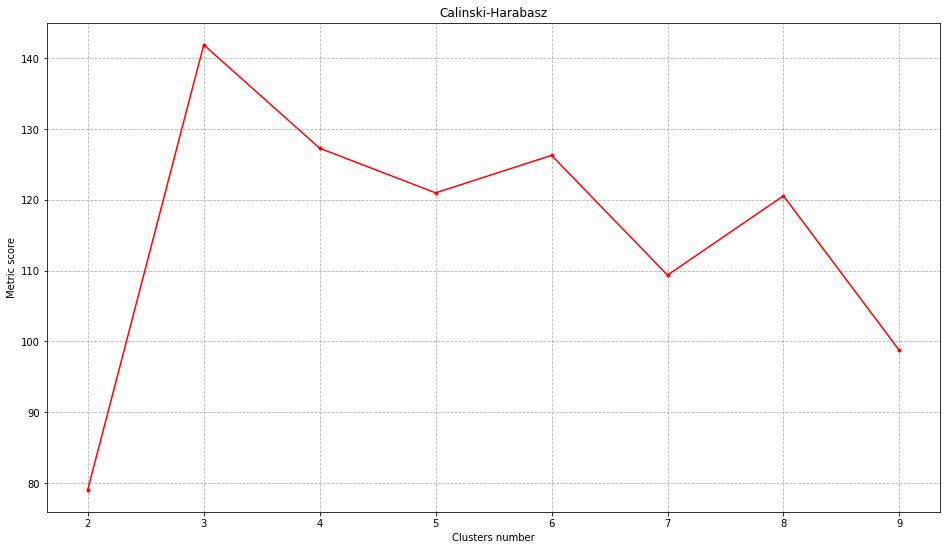

In [92]:
display_metrics(clusters_cnt, inner_metrics, "Calinski-Harabasz")

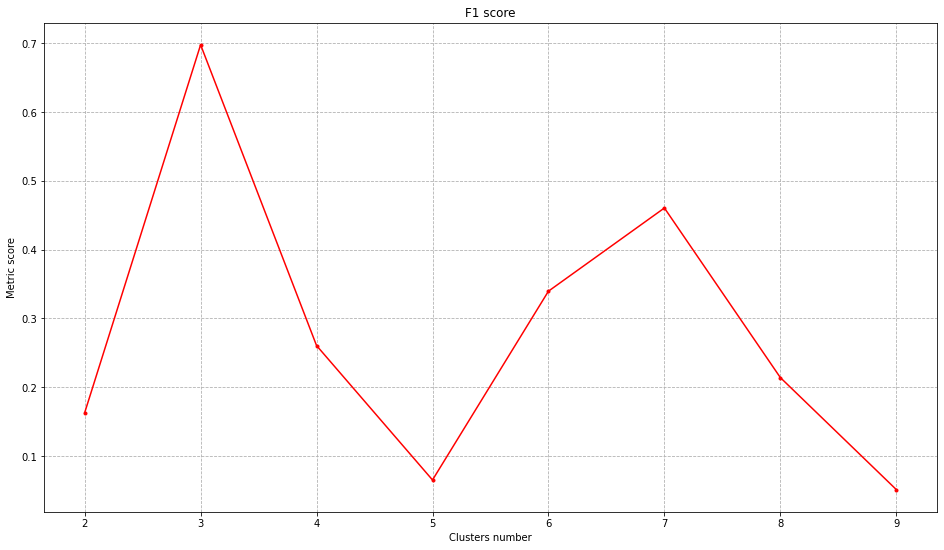

In [104]:
display_metrics(clusters_cnt, f1_scores, "F1 score")

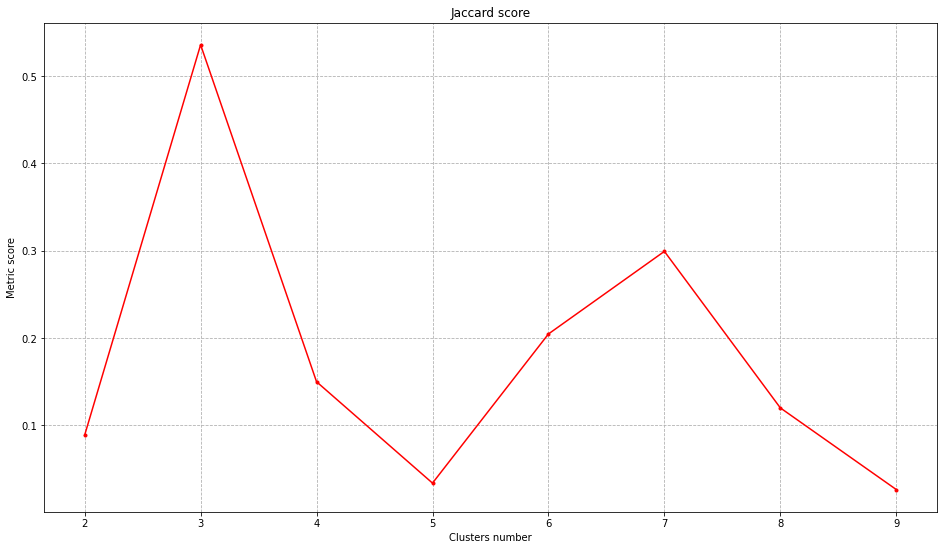

In [103]:
display_metrics(clusters_cnt, jaccard_scores, "Jaccard score")

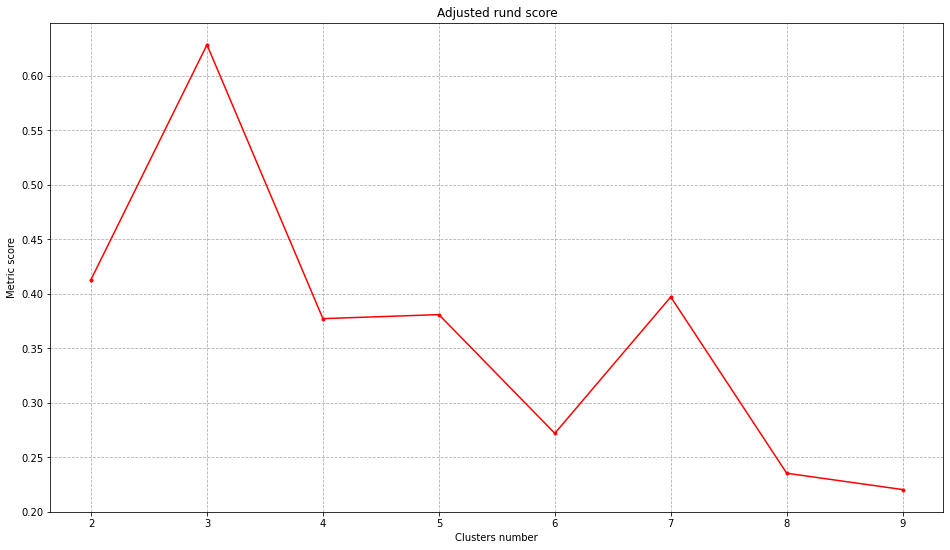

In [102]:
display_metrics(clusters_cnt, adjusted_rand_scores, "Adjusted rund score")